# CUPED

We call 'Controlled-experiment Using Pre-Experiment Data' (CUPED) a scenario where a treatment is randomly assigned to participants, and we have pre-experiment data of participants like pre-treatment outcome.

Treatment - new product category for users.

We will test hypothesis:

$H_o$ - There is no difference in LTV between treatment and control groups.

$H_a$ - There is a difference in LTV between treatment and control groups.

## Data

We will use DGP from Causalis. Read more at https://causalis.causalcraft.com/articles/make_cuped_tweedie_26

In [1]:
from causalis.scenarios.cuped.dgp import make_cuped_tweedie_26
from causalis.data_contracts import CausalData

data = make_cuped_tweedie_26(return_causal_data=False, include_oracle=True)
data.head()


,y,d,tenure_months,avg_sessions_week,spend_last_month,discount_rate,platform_ios,platform_web,m,m_obs,tau_link,g0,g1,cate,y_pre
0,0.000000,0.0,14.187461,2.0,57.355300,0.158164,0.0,0.0,0.5,0.5,0.042035,3.694528,3.853136,0.158608,0.000000
1,0.000000,1.0,6.352893,3.0,46.700946,0.085722,0.0,0.0,0.5,0.5,0.016201,3.694528,3.754870,0.060342,0.000000
2,12.918910,0.0,18.910153,9.0,80.136187,0.175115,1.0,0.0,0.5,0.5,0.188082,3.694528,4.459044,0.764516,219.374863
3,13.079312,1.0,7.927627,4.0,33.718224,0.152718,0.0,0.0,0.5,0.5,0.026540,3.694528,3.793893,0.099365,0.000000
4,0.000000,0.0,11.106925,2.0,92.064518,0.077390,0.0,0.0,0.5,0.5,0.029492,3.694528,3.805111,0.110583,0.000000


In [2]:
print(f"Ground truth ATE is {data['cate'].mean()}")
print(f"Ground truth ATTE is {data[data['d'] == 1]['cate'].mean()}")

Ground truth ATE is 0.2700720823988466
Ground truth ATTE is 0.27094666120202526


In [3]:
causaldata = CausalData(df = data,
                        treatment='d',
                        outcome='y',
                        confounders=['tenure_months', 'avg_sessions_week', 'spend_last_month', 'discount_rate', 'platform_ios', 'platform_web', 'y_pre'])
causaldata

CausalData(df=(100000, 9), treatment='d', outcome='y', confounders=['tenure_months', 'avg_sessions_week', 'spend_last_month', 'discount_rate', 'platform_ios', 'platform_web', 'y_pre'])

In [4]:
from causalis.shared import outcome_stats
outcome_stats(causaldata)

,treatment,count,mean,std,min,p10,p25,median,p75,p90,max
0,0.0,49868,8.496830,20.907555,0.0,0.0,0.0,0.0,8.903005,23.685134,637.127367
1,1.0,50132,9.056301,21.790102,0.0,0.0,0.0,0.0,9.523496,25.207978,764.333725


(<Figure size 1540x880 with 1 Axes>, <Figure size 1540x880 with 1 Axes>)

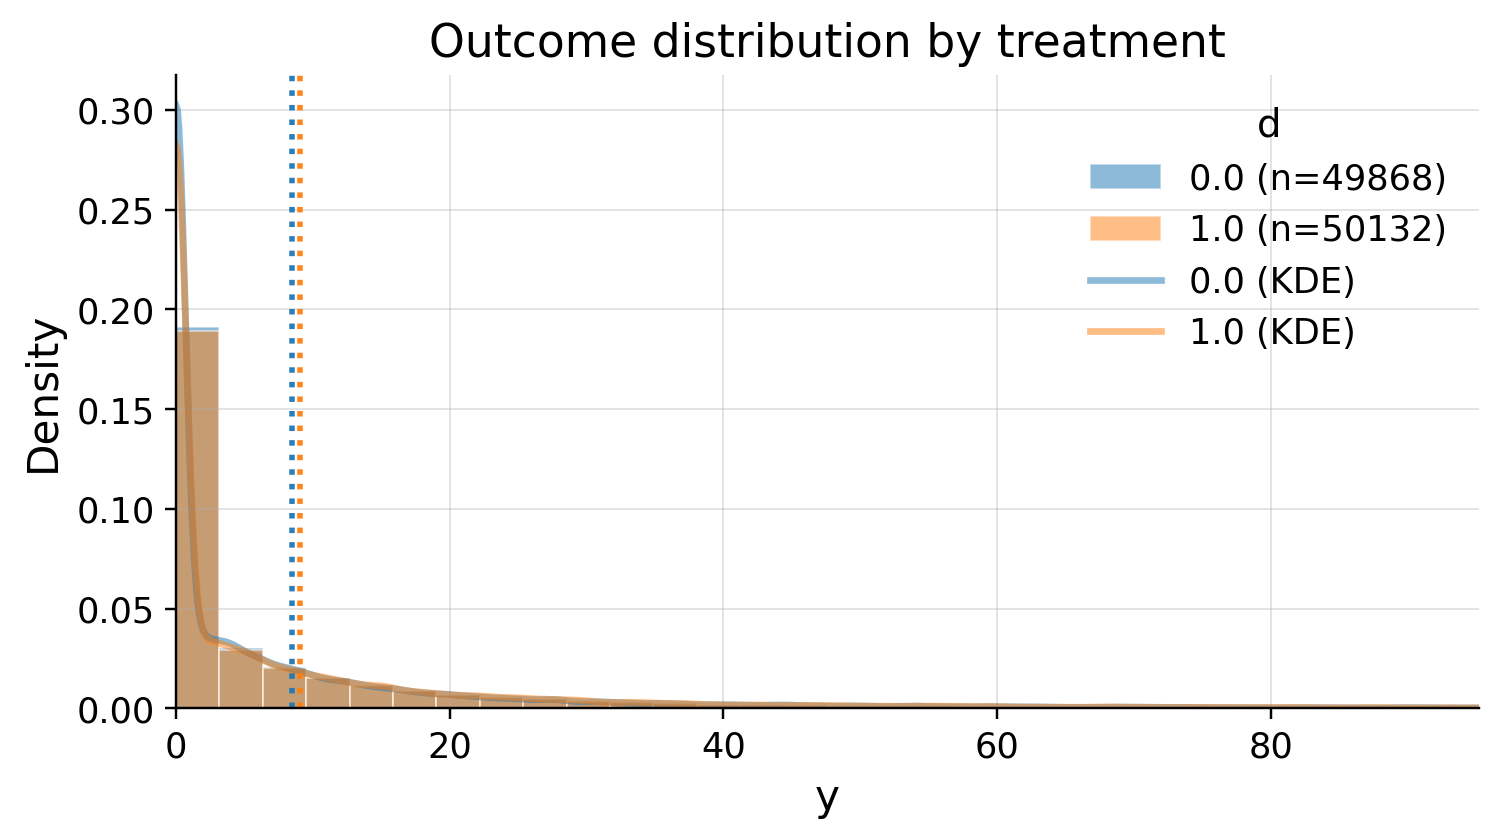

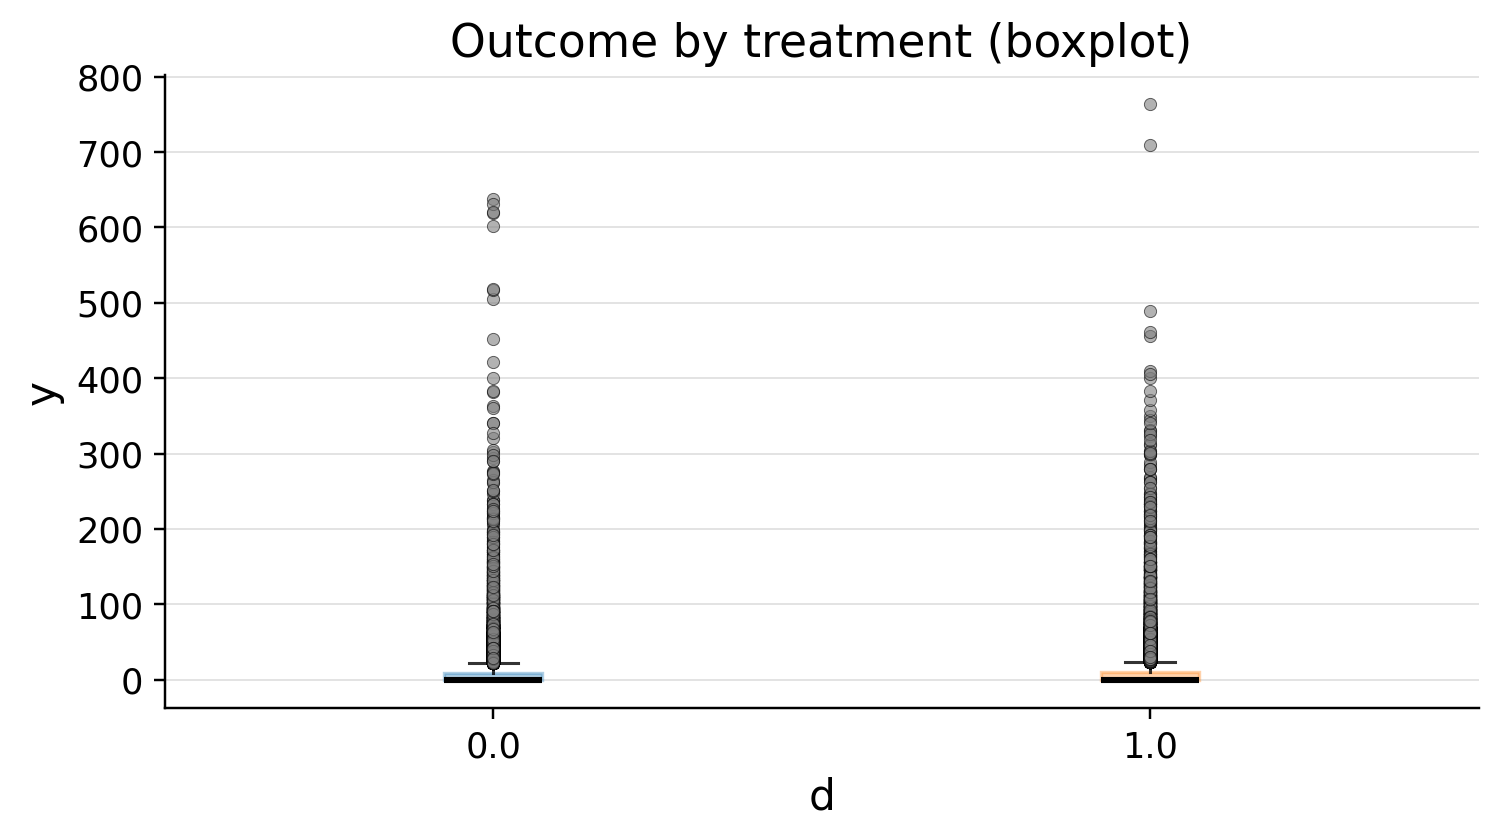

In [5]:
from causalis.shared import outcome_plots
outcome_plots(causaldata)

# Monitoring

Some system is randomly splitting users. Half must have new onboarding, other half has not. We should monitor the split with SRM test. Read more at https://causalis.causalcraft.com/articles/srm

In [6]:
from causalis.shared import check_srm

check_srm(assignments=causaldata, target_allocation={0: 0.5, 1: 0.5}, alpha=0.001)

SRMResult(status=no SRM, p_value=0.40381, chi2=0.6970, df=1)

In [7]:
from causalis.shared import confounders_balance

confounders_balance(causaldata)

,confounders,mean_d_0,mean_d_1,abs_diff,smd,ks_pvalue
0,platform_web,0.051356,0.048312,0.003043,-0.013985,0.97420
1,y_pre,15420.530166,51673.005274,36252.475108,0.008842,0.22562
2,tenure_months,13.756301,13.794400,0.038099,0.005198,0.56587
3,platform_ios,0.300032,0.301444,0.001412,0.003079,1.00000
4,avg_sessions_week,4.995969,5.003610,0.007641,0.001816,0.88605
5,spend_last_month,75.176560,75.263792,0.087232,0.001222,0.22678
6,discount_rate,0.100197,0.100129,0.000068,-0.001031,0.64488


# Inference

### Math of CUPEDModel

The `CUPEDModel` implements the Lin (2013) "interacted adjustment" for ATE (Average Treatment Effect) estimation in randomized controlled trials (RCTs). This method is a robust version of ANCOVA that remains valid even when the treatment effect is heterogeneous with respect to the covariates.


#### 1. Specification
The model fits an Ordinary Least Squares (OLS) regression of the outcome $Y$ on the treatment indicator $D$ and centered pre-treatment covariates $X^c$. The specification includes full interactions between the treatment and the centered covariates:

$$Y_i = \alpha + \tau D_i + \beta^T X_i^c + \gamma^T (D_i \cdot X_i^c) + \epsilon_i$$

Where:
- $Y_i$: Outcome for individual $i$.
- $D_i$: Binary treatment indicator ($D_i \in \{0, 1\}$).
- $X_i$: Vector of pre-treatment covariates.
- $X_i^c = X_i - \bar{X}$: Centered covariates (where $\bar{X}$ is the sample mean).
- $\alpha$: Intercept (represents the mean outcome of the control group when $X = \bar{X}$).
- $\tau$: **Average Treatment Effect (ATE)** or Intent-to-Treat (ITT) effect.
- $\beta$: Vector of coefficients for the main effects of the covariates.
- $\gamma$: Vector of coefficients for the interaction terms between treatment and covariates.
- $\epsilon_i$: Residual error term.


#### 2. Why Centering and Interaction?
- **Centering ($X^c$):** By centering the covariates, the coefficient $\tau$ directly represents the ATE at the average value of the covariates.
- **Interactions ($D \cdot X^c$):** Including interactions (as proposed by Lin, 2013) ensures that $\tau$ is a consistent estimator of the population ATE even if the true treatment effect varies with $X$ (heterogeneity). In traditional ANCOVA without interactions, the estimator for $\tau$ can be biased or less efficient under heterogeneity.


#### 3. Inference and Variance Reduction
The model uses robust covariance estimators (defaulting to `HC3`) to calculate standard errors, which accounts for potential heteroscedasticity:
- **Standard Error ($SE$):** Derived from the robust covariance matrix of the OLS fit.
- **Variance Reduction:** The main goal of CUPED is to reduce the variance of the ATE estimate by "soaking up" explainable variation in $Y$ using pre-treatment data $X$. The variance reduction percentage is calculated by comparing the variance of the adjusted model to a "naive" model ($Y \sim 1 + D$):
  $$\text{Variance Reduction \%} = 1 - \frac{Var(\hat{\tau}_{adjusted})}{Var(\hat{\tau}_{naive})}$$
  Note: For this specific metric, non-robust variances are typically used to directly reflect the reduction in residual sum of squares.


#### 4. Relative Effect
The relative treatment effect is calculated as:
$$\tau_{rel} = \frac{\tau}{\mu_c} \times 100\%$$
Where $\mu_c$ is the mean outcome of the control group ($D=0$).

In [8]:
from causalis.scenarios.cuped.cuped import CUPEDModel

model = CUPEDModel().fit(causaldata)

In [9]:
result = model.estimate()
result.summary()

,estimand,coefficient,p_val,lower_ci,upper_ci,relative_diff_%,is_significant
0,ATE,0.46103,0.000748,0.192999,0.729061,5.425902,True


In [10]:
result

CausalEstimate(estimand='ATE', model='CUPEDModel', model_options={'cov_type': 'HC3', 'use_t': True}, value=0.46102967151557134, ci_upper_absolute=0.7290606044359433, ci_lower_absolute=0.1929987385951994, value_relative=5.42590178262645, ci_upper_relative=8.580383167633265, ci_lower_relative=2.2714203976196345, alpha=0.05, p_value=0.0007484284834216089, is_significant=True, n_treated=50132, n_control=49868, outcome='y', treatment='x1', confounders=['tenure_months', 'avg_sessions_week', 'spend_last_month', 'discount_rate', 'platform_ios', 'platform_web', 'y_pre'], time=datetime.datetime(2026, 1, 18, 9, 39, 33, 950107), diagnostic_data=CUPEDDiagnosticData(ate_naive=0.559470355956976, se_naive=0.13504514109637034, variance_reduction_pct=4.894008398957583, beta_covariates=array([ 8.58229109e-03,  1.70169281e-02, -8.93659005e-04, -6.18793268e-01,
        5.50083631e-02, -2.72960344e-01,  4.41614684e-06]), gamma_interactions=array([ 1.71478690e-02,  5.80672828e-02, -5.40675202e-04,  1.0778709